In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 25.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp37-cp37m-linux_x86_64.whl size=3236593 sha256=ef51ace7338fef30142bbf87f270a63ebe7241fcdb869c07b3b59367fa5ddd94
  Stored in directory: /root/.cache/pip/wheels/5e/92/17/e718e0e26bfcdd7e81afcf874ac2bc599dd7dd7f3ad78f9d76
Successfully built spams


In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
#import spams
import cv2
from PIL import Image
import torchvision.transforms as T

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [ ]:
class Stain_Normalizer(object):
    def __init__(self):
        self.stain_matrix_target = None

    def fit(self, target):
        target = np.array(target.convert('RGB'))
        target = self.standardize_brightness(target)
        self.stain_matrix_target = self.get_stain_matrix(target)

    def target_stains(self):
        return self.OD_to_RGB(self.stain_matrix_target)

    def transform(self, img):
        img = np.array(img.convert('RGB'))
        img = self.standardize_brightness(img)
        stain_matrix_source = self.get_stain_matrix(img)
        source_concentrations = self.get_concentrations(img, stain_matrix_source)
        return Image.fromarray((255 * np.exp(-1 * np.dot(source_concentrations, self.stain_matrix_target).reshape(img.shape))).astype(
            np.uint8), 'RGB')

    def standardize_brightness(self, img):
      p = np.percentile(img, 90)
      return np.clip(img * 255.0 / p, 0, 255).astype(np.uint8)

    def RGB_to_OD(self, img):
      img = self.remove_zeros(img)
      return -1 * np.log(img / 255)

    def OD_to_RGB(self, OD):
        return (255 * np.exp(-1 * OD)).astype(np.uint8)

    def remove_zeros(self, img):
      mask = (img == 0)
      img[mask] = 1
      return img

    def get_concentrations(self, img, stain_matrix, lamda=0.01):
      OD = self.RGB_to_OD(img).reshape((-1, 3))
      return spams.lasso(OD.T, D=stain_matrix.T, mode=2, lambda1=lamda, pos=True).toarray().T

    def normalize_rows(self, A):
      return A / np.linalg.norm(A, axis=1)[:, None]


    def notwhite_mask(self, img, thresh=0.8):
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        L = img_lab[:, :, 0] / 255.0
        return (L < thresh)
    
    def get_stain_matrix(self, img, threshold=0.8, lamda=0.1):
      mask = self.notwhite_mask(img, thresh=threshold).reshape((-1,))
      OD = self.RGB_to_OD(img).reshape((-1, 3))
      OD = OD[mask]
      dictionary = spams.trainDL(OD.T, K=2, lambda1=lamda, mode=2, modeD=0, posAlpha=True, posD=True, verbose=False).T
      if dictionary[0, 0] < dictionary[1, 0]:
          dictionary = dictionary[[1, 0], :]
      dictionary = self.normalize_rows(dictionary)
      return dictionary


In [ ]:
# defining root and target paths
ROOT_PATH = "/content/drive/MyDrive/breast_new/40x/test/"

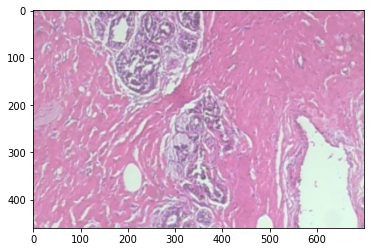

In [ ]:
# stain normalization by preserving structure of the first benign image
target_name = "SOB_B_A-14-22549G-40-013.png"
target = Image.open(ROOT_PATH + "benign/"+ target_name)
plt.imshow(target)

In [ ]:
normalizer = Stain_Normalizer()
normalizer.fit(target)

### Demo

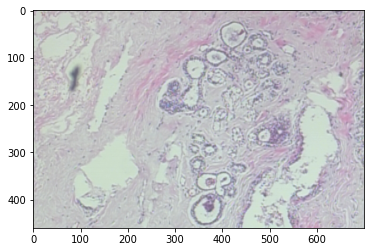

In [ ]:
img1 = Image.open(ROOT_PATH + "benign/SOB_B_A-14-22549AB-40-001.png")
plt.imshow(img1)

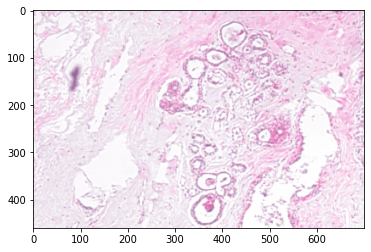

In [ ]:
img_stained = normalizer.transform(img1)
plt.imshow(img_stained)

In [ ]:
def img_to_patch(x, patch_size):
  H, W, C = x.shape
  ls = []
  for i in range(0, H-1, patch_size):
    for j in range(0, W-1, patch_size):
      ls.append(torch.from_numpy(x[i:i+patch_size, j:j+patch_size, :]).permute(2, 0, 1))

  return ls

    

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
patches = img_to_patch(np.array(img1.resize((224, 224))), 16)
patches[0].shape

torch.Size([3, 16, 16])

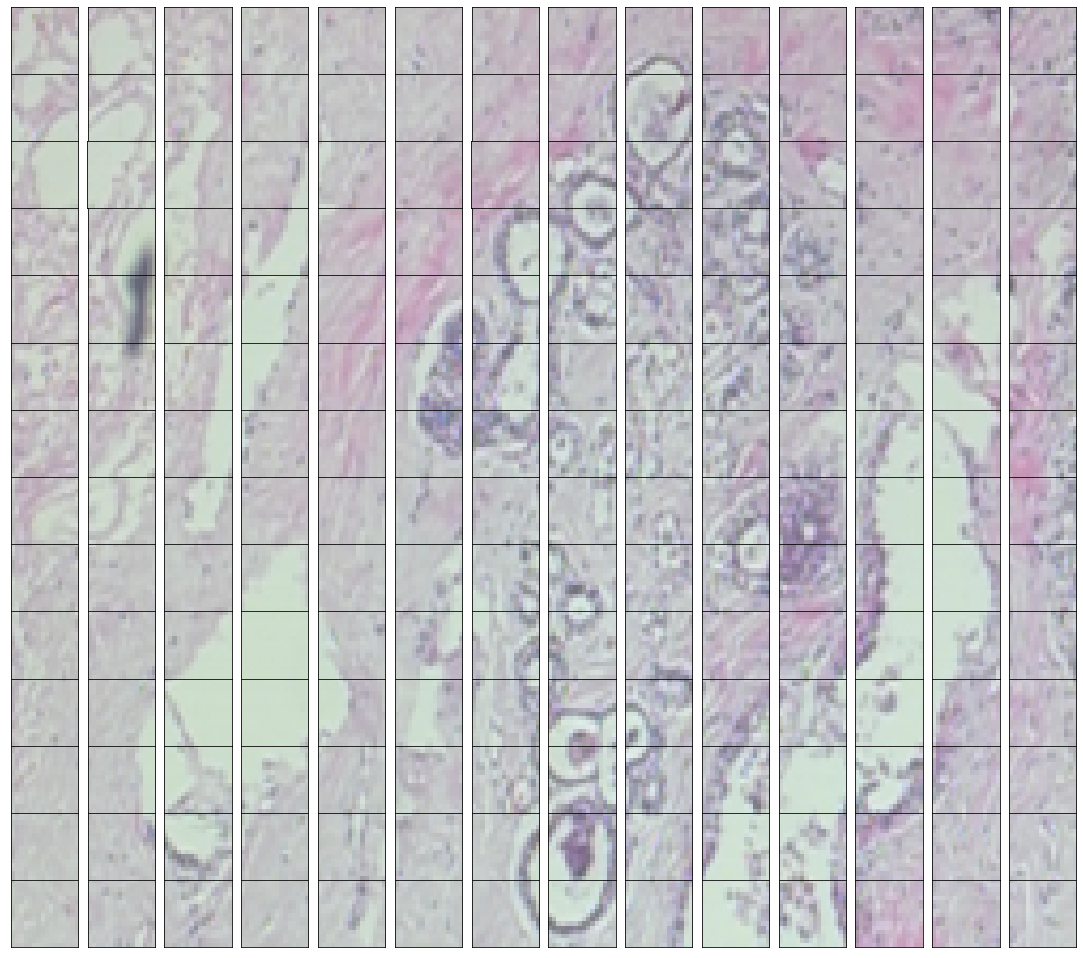

In [ ]:
from matplotlib import gridspec
n = 14
gs = gridspec.GridSpec(n, n,
                       top=1.-0.5/(n+1), bottom=0.5/(n+1),
                       left=0.5/(n+1), right=1-0.5/(n+1),
                       wspace=0.0, hspace=0.0) 

k = 0
for i in range(14):
    for j in range(14):
        im = patches[k+j, :, :, :]
        ax= plt.subplot(gs[i,j])
        ax.imshow(im)
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    k += 14

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (16, 14)
def show(imgs):
    ax = [plt.subplot(14,14,i+1) for i in range(196)]

    for i, a in enumerate(ax):
        a.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        img = imgs[i, :, :, :]
        a.imshow(img)

    plt.subplots_adjust(wspace=0, hspace=0)

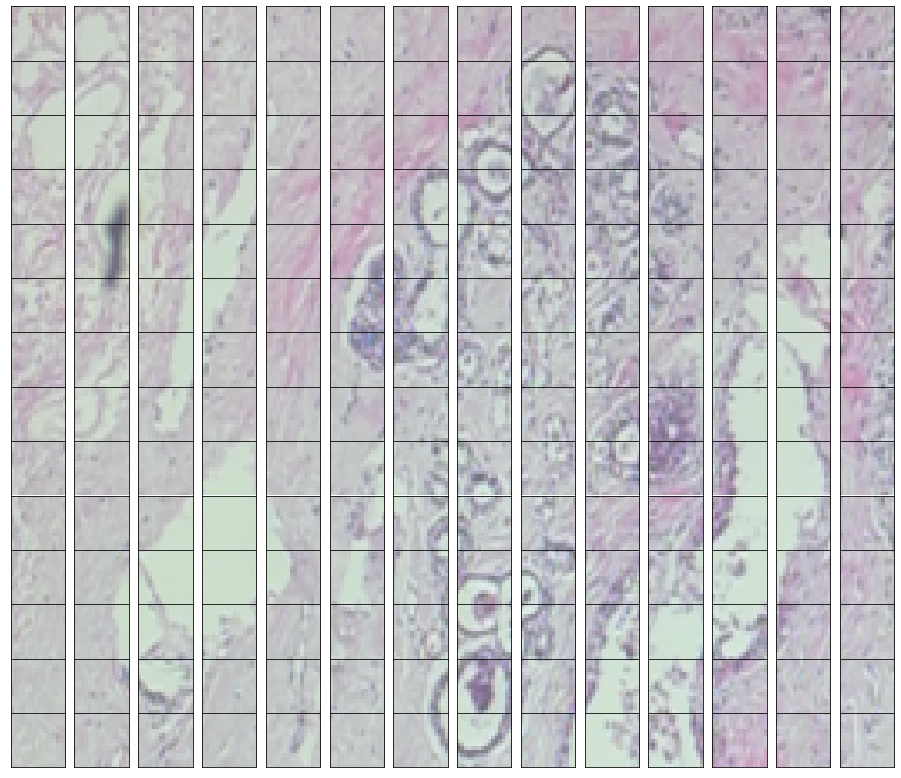

In [ ]:
show(patches)

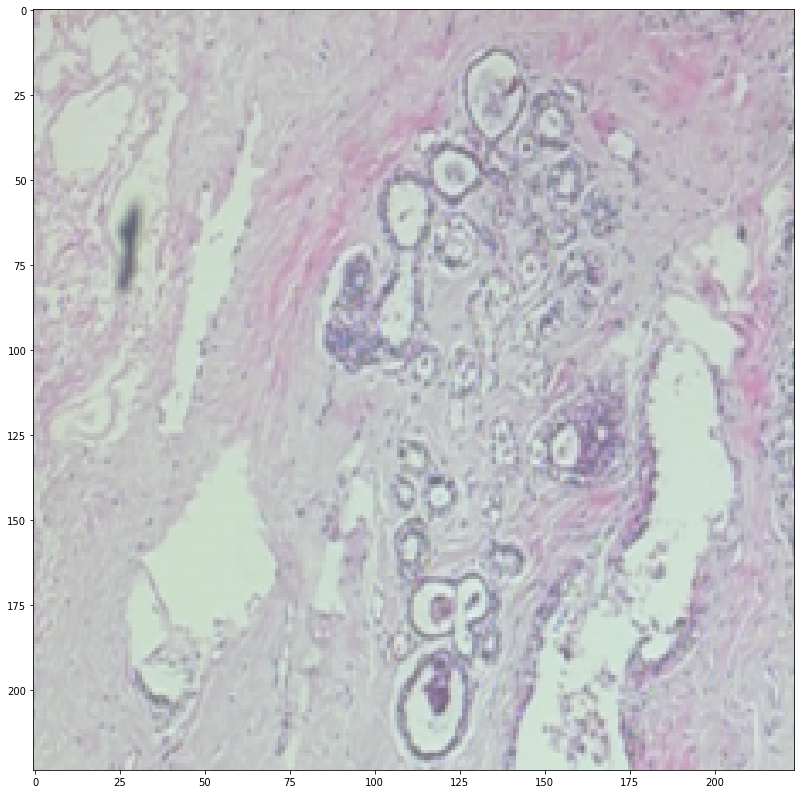

In [ ]:
plt.imshow(np.array(img1.resize((224, 224))))

In [ ]:
img = np.array(img_stained.resize((224, 224)))

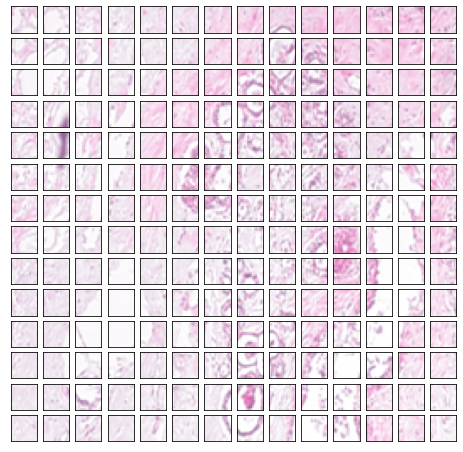

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.add_axes()
ls = []
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)
    if (i <= 3) or (i >= 192):
      ls.append(patch)

In [ ]:
Image.fromarray(ls[5])

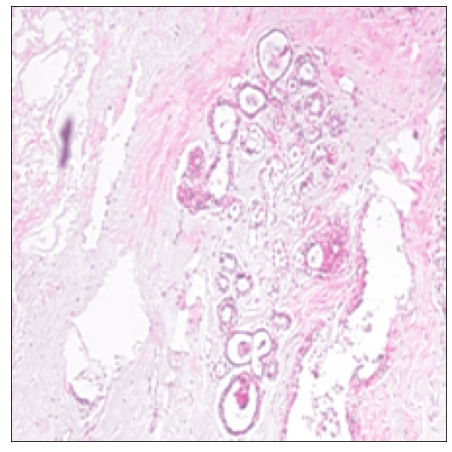

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.imshow(img)

In [ ]:
img.shape

AttributeError: ignored

TypeError: ignored

<Figure size 576x576 with 0 Axes>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(nrows=14, ncols=14, squeeze=False)
    k = 14
    for i in range(14):
      for j in range(14):
        img = imgs[j+k, :, :, :].detach()
        img = F.to_pil_image(img)
        axs[i, j].imshow(np.asarray(img))
        axs[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
      
      k += 14

In [ ]:
import torchvision
grid_img = torchvision.utils.make_grid(patches, nrow=14, padding=1)
img = torchvision.transforms.ToPILImage()(grid_img)

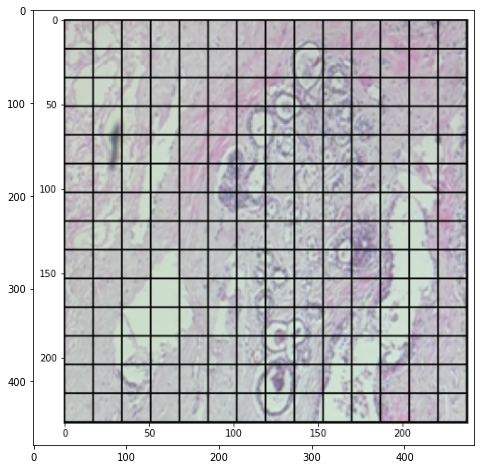

In [ ]:
plt.imshow(Image.open('/content/drive/MyDrive/patches.png'))

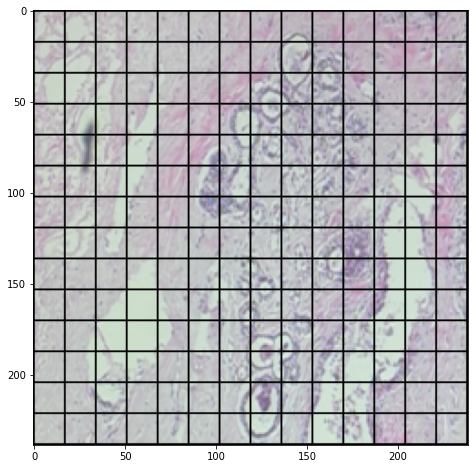

In [ ]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (8, 8)
ax.imshow()

In [ ]:
fig.savefig("/content/drive/MyDrive/patches.png")

TypeError: ignored

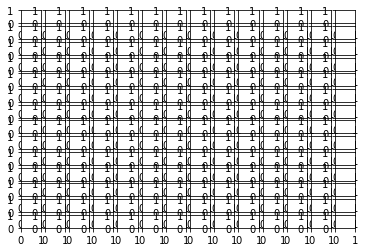

In [ ]:
show(grid_img)

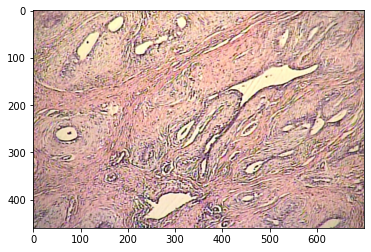

In [ ]:
img2 = Image.open(ROOT_PATH + "benign/SOB_B_F-14-23060AB-40-010.png")
plt.imshow(img2)

In [ ]:
img_stained = normalizer.transform(img2)

img_HF = T.RandomHorizontalFlip(p=1)(img_stained)

# Vertical Flip
img_VF = T.RandomVerticalFlip(p=1)(img_stained)
# Center Crop
img_CC = T.CenterCrop(size=(224, 224))(img_stained)

# Rotate 30 and 60 degrees, counterclockwise
img_rot_30 = img_stained.rotate(angle=30)
img_rot_60 = img_stained.rotate(angle=60)

# Random Shear
affine_transfomer = T.RandomAffine(degrees=0, shear=(0.3, 0.5))
img_AT1, img_AT2 = [affine_transfomer(img_stained) for _ in range(2)]

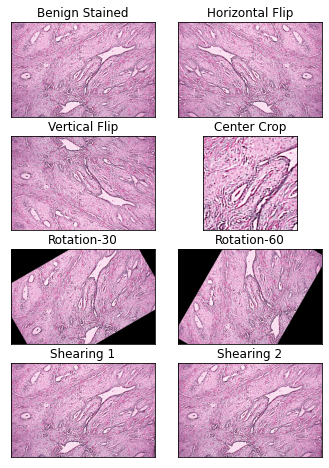

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(6, 8))

axes[0, 0].set_title("Benign Stained")
axes[0, 0].imshow(img_stained)
axes[0, 0].axes.get_xaxis().set_visible(False)
axes[0, 0].axes.get_yaxis().set_visible(False)

axes[0, 1].set_title("Horizontal Flip")
axes[0, 1].imshow(img_HF)
axes[0, 1].axes.get_xaxis().set_visible(False)
axes[0, 1].axes.get_yaxis().set_visible(False)

axes[1, 0].set_title("Vertical Flip")
axes[1, 0].imshow(img_VF)
axes[1, 0].axes.get_xaxis().set_visible(False)
axes[1, 0].axes.get_yaxis().set_visible(False)

axes[1, 1].set_title("Center Crop")
axes[1, 1].imshow(img_CC)
axes[1, 1].axes.get_xaxis().set_visible(False)
axes[1, 1].axes.get_yaxis().set_visible(False)

axes[2, 0].set_title("Rotation-30")
axes[2, 0].imshow(img_rot_30)
axes[2, 0].axes.get_xaxis().set_visible(False)
axes[2, 0].axes.get_yaxis().set_visible(False)

axes[2, 1].set_title("Rotation-60")
axes[2, 1].imshow(img_rot_60)
axes[2, 1].axes.get_xaxis().set_visible(False)
axes[2, 1].axes.get_yaxis().set_visible(False)

axes[3, 0].set_title("Shearing 1")
axes[3, 0].imshow(img_AT1)
axes[3, 0].axes.get_xaxis().set_visible(False)
axes[3, 0].axes.get_yaxis().set_visible(False)

axes[3, 1].set_title("Shearing 2")
axes[3, 1].imshow(img_AT2)
axes[3, 1].axes.get_xaxis().set_visible(False)
axes[3, 1].axes.get_yaxis().set_visible(False)

plt.subplots_adjust(wspace=0)

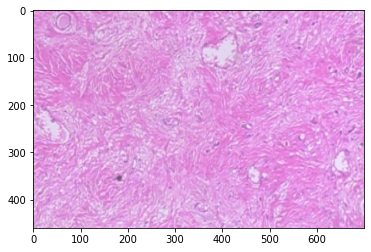

In [ ]:
img3 = Image.open(ROOT_PATH + "lobular_carcinoma/SOB_M_LC-14-15570-40-042.png")
plt.imshow(img3)

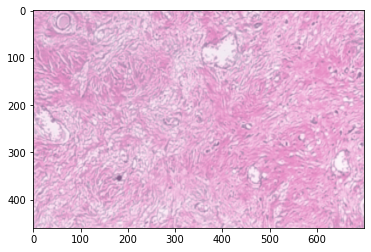

In [ ]:
img_stained = normalizer.transform(img3)
plt.imshow(img_stained)

# ALL

* Benign 2480
* Ductal Carcinoma 3451
* Lobular Carcinoma 626
* Mucinous Carcinoma 792
* Papillary Carcinoma 560

## Benign 625
* Train 1736
* Test 744

In [ ]:
import torchvision
from torchvision import transforms
def load_file(path):
  return Image.open(path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.DatasetFolder(
    root="/content/drive/MyDrive/breast_new/40x/test",
    loader=load_file, extensions="png", transform=transform)

In [ ]:
test_dataset[125]

(tensor([[[ 1.8893,  1.9920,  1.7180,  ...,  1.2385,  1.2214,  0.9817],
          [ 1.9578,  2.0777,  1.9578,  ...,  1.6838,  1.4954,  1.2899],
          [ 1.9064,  2.0434,  2.0777,  ...,  1.8208,  1.8379,  1.7694],
          ...,
          [ 1.9407,  2.0434,  2.1290,  ...,  1.4783,  0.5193,  0.8618],
          [ 2.0092,  2.1119,  2.1462,  ...,  1.5639,  0.8789,  0.9988],
          [ 1.9920,  2.0948,  2.1462,  ...,  1.8379,  1.7352,  1.7352]],
 
         [[ 1.7983,  1.7983,  1.5707,  ..., -0.3725, -0.3200, -0.1450],
          [ 1.9034,  1.8683,  1.7808,  ...,  0.2052, -0.0924,  0.1001],
          [ 1.8508,  1.8333,  1.8158,  ...,  0.5378,  0.5553,  0.7479],
          ...,
          [ 1.8859,  1.8859,  1.8859,  ...,  0.6429, -0.0749,  0.1001],
          [ 1.9034,  1.9034,  1.9034,  ...,  0.6429,  0.2227,  0.2227],
          [ 1.8859,  1.8683,  1.8683,  ...,  0.5903,  0.7479,  0.8354]],
 
         [[ 2.2740,  2.2914,  2.0997,  ...,  0.9842,  1.0191,  1.0365],
          [ 2.3263,  2.3611,

In [ ]:
c = 0

for file in glob.glob(ROOT_PATH + "benign/*.png"):
  
  image_name = file.split('/')[-1][:-4]
  
  img = normalizer.transform(Image.open(file))

  if c < 1736: # training images
    target_path = ROOT_PATH + "train/benign/"
    img.save(target_path + image_name + ".png")
    """
    # Horizontal Flip
    img_HF = T.RandomHorizontalFlip(p=1)(img)
    img_HF.save(target_path + image_name + "-HF.png")

    # Vertical Flip
    img_VF = T.RandomVerticalFlip(p=1)(img)
    img_VF.save(target_path + image_name + "-VF.png")

    # Center Crop
    img_CC = T.CenterCrop(size=(224, 224))(img)
    img_CC.save(target_path + image_name +  "-CC.png")

    # Rotate 30 and 60 degrees, counterclockwise
    img_rot_30 = img.rotate(angle=30)
    img_rot_60 = img.rotate(angle=60)

    img_rot_30.save(target_path + image_name + "-rot-30.png")
    img_rot_60.save(target_path + image_name + "-rot-60.png")

    # Random Shear
    affine_transfomer = T.RandomAffine(degrees=0, shear=(0.3, 0.5))
    img_AT1, img_AT2 = [affine_transfomer(img) for _ in range(2)]

    img_AT1.save(target_path + image_name + "-AT1.png")
    img_AT2.save(target_path + image_name + "-AT-2.png")
    """

  else:
    target_path = ROOT_PATH + "test/benign/"
    img.save(target_path + image_name + ".png")
  c += 1

In [ ]:
c

560

## Ductal Carcinoma 3451
* Train 2415
* Test 1036

In [ ]:
c = 0

for file in glob.glob(ROOT_PATH + "ductal_carcinoma/*.png"):
  image_name = file.split('/')[-1][:-4]
  
  img = normalizer.transform(Image.open(file))

  if c < 2415: # training images
    target_path = ROOT_PATH + "train/ductal_carcinoma/"
    img.save(target_path + image_name + ".png")
    """
    # Horizontal Flip
    img_HF = T.RandomHorizontalFlip(p=1)(img)
    img_HF.save(target_path + image_name + "-HF.png")

    # Vertical Flip
    img_VF = T.RandomVerticalFlip(p=1)(img)
    img_VF.save(target_path + image_name + "-VF.png")

    # Center Crop
    img_CC = T.CenterCrop(size=(224, 224))(img)
    img_CC.save(target_path + image_name +  "-CC.png")

    # Rotate 30 Degrees Counterclockwise
    img_rot_30 = img.rotate(angle=30)
    img_rot_30.save(target_path + image_name +  "-rot-30.png")

    # Random Shear
    img_AT = T.RandomAffine(degrees=0, shear=(0.3, 0.5))(img)
    img_AT.save(target_path + image_name + "-AT.png")
    """

  else:
    target_path = ROOT_PATH + "test/ductal_carcinoma/"
    img.save(target_path + image_name + ".png")

  c += 1

## Lobular Corcinoma 626
* Train 438
* Test 188

In [ ]:
c = 0

for file in glob.glob(ROOT_PATH + "lobular_carcinoma/*.png"):
  image_name = file.split('/')[-1][:-4]
  
  img = normalizer.transform(Image.open(file))

  if c < 438: # training images
    target_path = ROOT_PATH + "train/lobular_carcinoma/"
    img.save(target_path + image_name + ".png")
    """
    # Horizontal Flip
    img_HF = T.RandomHorizontalFlip(p=1)(img)
    img_HF.save(target_path + image_name + "-HF.png")

    # Vertical Flip
    img_VF = T.RandomVerticalFlip(p=1)(img)
    img_VF.save(target_path + image_name + "-VF.png")

    # Five Crop 
    img_FC1, img_FC2, img_FC3, img_FC4, img_FC5 = T.FiveCrop(size=(224, 224))(img)

    img_FC1.save(target_path + image_name + "-FC1.png")
    img_FC2.save(target_path + image_name + "-FC2.png")
    img_FC3.save(target_path + image_name + "-FC3.png")
    img_FC4.save(target_path + image_name + "-FC4.png")
    img_FC5.save(target_path + image_name + "-FC5.png")

    # Color Jitter - 5 times
    color_jitter = T.ColorJitter(brightness=0.5, hue=0.3, saturation=0.4)
    img_CJ1, img_CJ2, img_CJ3, img_CJ4, img_CJ5 = [color_jitter(img) for _ in range(5)]

    img_CJ1.save(target_path + image_name + "-CJ1.png")
    img_CJ2.save(target_path + image_name + "-CJ2.png")
    img_CJ3.save(target_path + image_name + "-CJ3.png")
    img_CJ4.save(target_path + image_name + "-CJ4.png")
    img_CJ5.save(target_path + image_name + "-CJ5.png")

    # Random Affine - 5 times
    random_affine = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.4))
    img_RA1, img_RA2, img_RA3, img_RA4, img_RA5 = [ random_affine(img) for _ in range(5)]

    img_RA1.save(target_path + image_name + "-RA1.png")
    img_RA2.save(target_path + image_name + "-RA2.png")
    img_RA3.save(target_path + image_name + "-RA3.png")
    img_RA4.save(target_path + image_name + "-RA4.png")
    img_RA5.save(target_path + image_name + "-RA5.png")

    # Color Jitter on Five Crops
    img_FC1_CJ = color_jitter(img_FC1)
    img_FC2_CJ = color_jitter(img_FC2)
    img_FC3_CJ = color_jitter(img_FC3)
    img_FC4_CJ = color_jitter(img_FC4)
    img_FC5_CJ = color_jitter(img_FC5)

    img_FC1_CJ.save(target_path + image_name + "-FC1-CJ.png")
    img_FC2_CJ.save(target_path + image_name + "-FC2-CJ.png")
    img_FC3_CJ.save(target_path + image_name + "-FC3-CJ.png")
    img_FC4_CJ.save(target_path + image_name + "-FC4-CJ.png")
    img_FC5_CJ.save(target_path + image_name + "-FC5-CJ.png")

    # Random Shear on original image, horizontal and vertical flipped image
    random_shear = T.RandomAffine(degrees=0, shear=(0.1, 0.4))
    img_RS1, img_RS2, img_RS3, img_RS4, img_RS5, img_RS6 = [random_shear(img) for _ in range(6)]
    img_HF_RS = random_shear(img_HF)
    img_VF_RS = random_shear(img_VF)

    img_RS1.save(target_path + image_name + "-RS1.png")
    img_RS2.save(target_path + image_name + "-RS2.png")
    img_RS3.save(target_path + image_name + "-RS3.png")
    img_RS4.save(target_path + image_name + "-RS4.png")
    img_RS5.save(target_path + image_name + "-RS5.png")
    img_RS6.save(target_path + image_name + "-RS6.png")

    img_HF_RS.save(target_path + image_name + "-HF-RS.png")
    img_VF_RS.save(target_path + image_name + "-VF-RS.png")
    
  elif c < 125:
    target_path = OUTPUT_PATH + "val/lobular_carcinoma/"
    img.save(target_path + image_name + ".png")
  """
  else:
    target_path = ROOT_PATH + "test/lobular_carcinoma/"
    img.save(target_path + image_name + ".png")

  c += 1

Mucinous 792
* Train 554
* Test 238

In [ ]:
c = 0

for file in glob.glob(ROOT_PATH + "mucinous_carcinoma/*.png"):
  image_name = file.split('/')[-1][:-4]
  
  img = normalizer.transform(Image.open(file))

  if c < 554: # training images
    target_path = ROOT_PATH + "train/mucinous_carcinoma/"
    img.save(target_path + image_name + ".png")
    """
    # Horizontal Flip
    img_HF = T.RandomHorizontalFlip(p=1)(img)
    img_HF.save(target_path + image_name + "-HF.png")

    # Vertical Flip
    img_VF = T.RandomVerticalFlip(p=1)(img)
    img_VF.save(target_path + image_name + "-VF.png")

    # Five Crop 
    img_FC1, img_FC2, img_FC3, img_FC4, img_FC5 = T.FiveCrop(size=(224, 224))(img)

    img_FC1.save(target_path + image_name + "-FC1.png")
    img_FC2.save(target_path + image_name + "-FC2.png")
    img_FC3.save(target_path + image_name + "-FC3.png")
    img_FC4.save(target_path + image_name + "-FC4.png")
    img_FC5.save(target_path + image_name + "-FC5.png")

    # Color Jitter - 3 times
    color_jitter = T.ColorJitter(brightness=0.5, hue=0.3, saturation=0.4)
    img_CJ1, img_CJ2, img_CJ3 = [color_jitter(img) for _ in range(3)]

    img_CJ1.save(target_path + image_name + "-CJ1.png")
    img_CJ2.save(target_path + image_name + "-CJ2.png")
    img_CJ3.save(target_path + image_name + "-CJ3.png")

    # Random Affine - 5 times
    random_affine = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.4))
    img_RA1, img_RA2, img_RA3, img_RA4, img_RA5 = [ random_affine(img) for _ in range(5)]

    img_RA1.save(target_path + image_name + "-RA1.png")
    img_RA2.save(target_path + image_name + "-RA2.png")
    img_RA3.save(target_path + image_name + "-RA3.png")
    img_RA4.save(target_path + image_name + "-RA4.png")
    img_RA5.save(target_path + image_name + "-RA5.png")

    # Color Jitter on 3 of Five Crops 
    img_FC1_CJ = color_jitter(img_FC1)
    img_FC3_CJ = color_jitter(img_FC3)
    img_FC5_CJ = color_jitter(img_FC5)

    img_FC1_CJ.save(target_path + image_name + "-FC1-CJ.png")
    img_FC3_CJ.save(target_path + image_name + "-FC3-CJ.png")
    img_FC5_CJ.save(target_path + image_name + "-FC5-CJ.png")

    # Random Shear on original image, horizontal and vertical flipped image
    random_shear = T.RandomAffine(degrees=0, shear=(0.1, 0.4))
    img_RS1, img_RS2, img_RS3 = [random_shear(img) for _ in range(3)]
    img_HF_RS = random_shear(img_HF)
    img_VF_RS = random_shear(img_VF)

    img_RS1.save(target_path + image_name + "-RS1.png")
    img_RS2.save(target_path + image_name + "-RS2.png")
    img_RS3.save(target_path + image_name + "-RS3.png")

    img_HF_RS.save(target_path + image_name + "-HF-RS.png")
    img_VF_RS.save(target_path + image_name + "-VF-RS.png")
    
  elif c < 164:
    target_path = OUTPUT_PATH + "val/mucinous_carcinoma/"
    img.save(target_path + image_name + ".png")
  """
  else:
    target_path = ROOT_PATH + "test/mucinous_carcinoma/"
    img.save(target_path + image_name + ".png")

  c += 1

Papillary Carcinoma 560
* Train 392
* Test 168

In [ ]:
c = 0

for file in glob.glob(ROOT_PATH + "papillary_carcinoma/*.png"):
  image_name = file.split('/')[-1][:-4]
  
  img = normalizer.transform(Image.open(file))

  if c < 392: # training images
    target_path = ROOT_PATH + "train/papillary_carcinoma/"
    img.save(target_path + image_name + ".png")
    """
    # Horizontal Flip
    img_HF = T.RandomHorizontalFlip(p=1)(img)
    img_HF.save(target_path + image_name + "-HF.png")

    # Vertical Flip
    img_VF = T.RandomVerticalFlip(p=1)(img)
    img_VF.save(target_path + image_name + "-VF.png")

    # Five Crop 
    img_FC1, img_FC2, img_FC3, img_FC4, img_FC5 = T.FiveCrop(size=(224, 224))(img)

    img_FC1.save(target_path + image_name + "-FC1.png")
    img_FC2.save(target_path + image_name + "-FC2.png")
    img_FC3.save(target_path + image_name + "-FC3.png")
    img_FC4.save(target_path + image_name + "-FC4.png")
    img_FC5.save(target_path + image_name + "-FC5.png")

    # Color Jitter - 5 times
    color_jitter = T.ColorJitter(brightness=0.5, hue=0.3, saturation=0.4)
    img_CJ1, img_CJ2, img_CJ3, img_CJ4, img_CJ5 = [color_jitter(img) for _ in range(5)]

    img_CJ1.save(target_path + image_name + "-CJ1.png")
    img_CJ2.save(target_path + image_name + "-CJ2.png")
    img_CJ3.save(target_path + image_name + "-CJ3.png")
    img_CJ4.save(target_path + image_name + "-CJ4.png")
    img_CJ5.save(target_path + image_name + "-CJ5.png")

    # Random Affine - 5 times
    random_affine = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.4))
    img_RA1, img_RA2, img_RA3, img_RA4, img_RA5 = [ random_affine(img) for _ in range(5)]

    img_RA1.save(target_path + image_name + "-RA1.png")
    img_RA2.save(target_path + image_name + "-RA2.png")
    img_RA3.save(target_path + image_name + "-RA3.png")
    img_RA4.save(target_path + image_name + "-RA4.png")
    img_RA5.save(target_path + image_name + "-RA5.png")

    # Color Jitter on Five Crops
    img_FC1_CJ = color_jitter(img_FC1)
    img_FC2_CJ = color_jitter(img_FC2)
    img_FC3_CJ = color_jitter(img_FC3)
    img_FC4_CJ = color_jitter(img_FC4)
    img_FC5_CJ = color_jitter(img_FC5)

    img_FC1_CJ.save(target_path + image_name + "-FC1-CJ.png")
    img_FC2_CJ.save(target_path + image_name + "-FC2-CJ.png")
    img_FC3_CJ.save(target_path + image_name + "-FC3-CJ.png")
    img_FC4_CJ.save(target_path + image_name + "-FC4-CJ.png")
    img_FC5_CJ.save(target_path + image_name + "-FC5-CJ.png")

    # Random Shear on original image, horizontal and vertical flipped image
    random_shear = T.RandomAffine(degrees=0, shear=(0.1, 0.4))
    img_RS1, img_RS2, img_RS3, img_RS4, img_RS5, img_RS6 = [random_shear(img) for _ in range(6)]

    img_HF_RS = random_shear(img_HF)
    img_VF_RS = random_shear(img_VF)

    img_FC1_RS = random_shear(img_FC1)
    img_FC2_RS = random_shear(img_FC2)
    img_FC3_RS = random_shear(img_FC3)

    img_RS1.save(target_path + image_name + "-RS1.png")
    img_RS2.save(target_path + image_name + "-RS2.png")
    img_RS3.save(target_path + image_name + "-RS3.png")
    img_RS4.save(target_path + image_name + "-RS4.png")
    img_RS5.save(target_path + image_name + "-RS5.png")
    img_RS6.save(target_path + image_name + "-RS6.png")

    img_HF_RS.save(target_path + image_name + "-HF-RS.png")
    img_VF_RS.save(target_path + image_name + "-VF-RS.png")

    img_FC1_RS.save(target_path + image_name + "-FC1-RS.png")
    img_FC2_RS.save(target_path + image_name + "-FC2-RS.png")
    img_FC3_RS.save(target_path + image_name + "-FC3-RS.png")
    
  elif c < 125:
    target_path = OUTPUT_PATH + "val/papillary_carcinoma/"
    img.save(target_path + image_name + ".png")
  """
  else:
    target_path = ROOT_PATH + "test/papillary_carcinoma/"
    img.save(target_path + image_name + ".png")

  c += 1